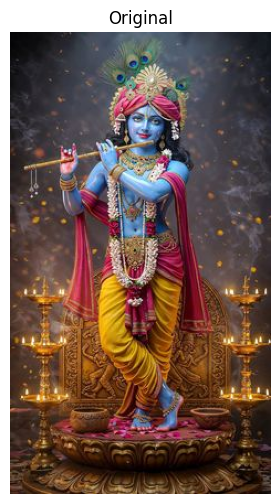

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

def imshow_rgb(img, title=None):
    img = np.clip(img,0,255).astype(np.uint8)
    plt.imshow(img); plt.axis('off')
    if title: plt.title(title)

# load image
path = '/content/kanhaji.jpg'
img_bgr = cv2.imread(path)
if img_bgr is None:
    # fallback if path different
    img_pil = Image.open('/content/kanhaji.jpg').convert('RGB')
    img_rgb = np.array(img_pil)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
else:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure()
imshow_rgb(img_rgb, "Original")
plt.show()

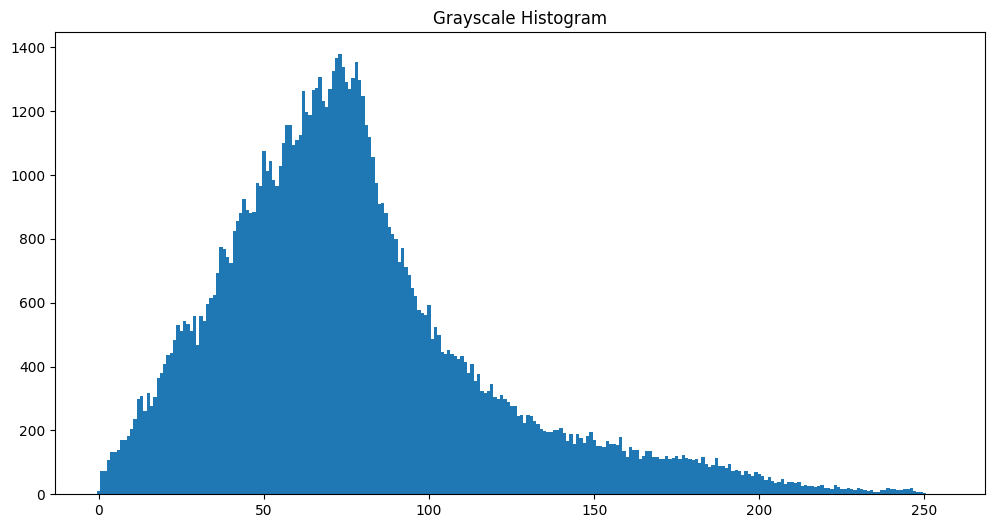

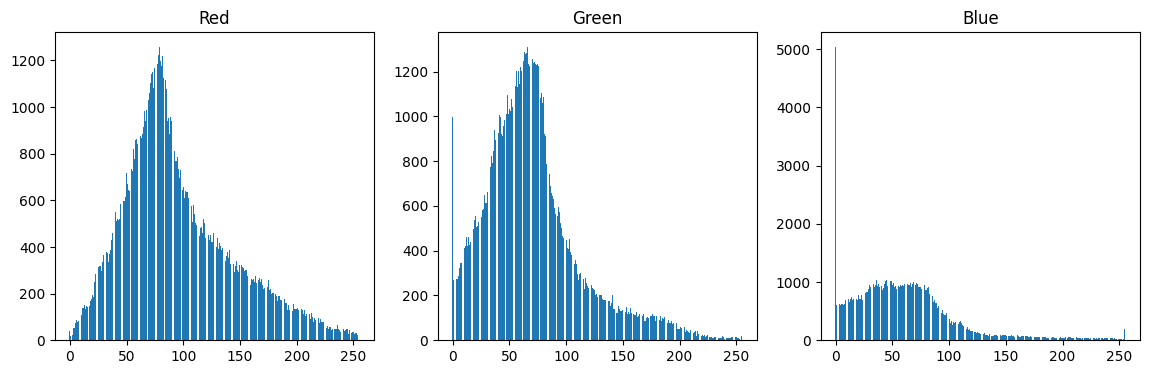

In [2]:
#part A

def gray_histogram(gray_img):
    hist = np.zeros(256, dtype=np.int64)
    h,w = gray_img.shape
    for i in range(h):
        row = gray_img[i]
        for j in range(w):
            hist[int(row[j])] += 1
    return hist

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
hist_gray = gray_histogram(gray)
plt.figure()
plt.bar(np.arange(256), hist_gray, width=1)
plt.title("Grayscale Histogram")
plt.show()

def rgb_histogram(rgb):
    h,w,_ = rgb.shape
    hr = np.zeros(256, int)
    hg = np.zeros(256, int)
    hb = np.zeros(256, int)
    for i in range(h):
        for j in range(w):
            r,g,b = int(rgb[i,j,0]), int(rgb[i,j,1]), int(rgb[i,j,2])
            hr[r]+=1
            hg[g]+=1
            hb[b]+=1
    return hr,hg,hb

hr,hg,hb = rgb_histogram(img_rgb)
x = np.arange(256)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.bar(x, hr)
plt.title("Red")
plt.subplot(1,3,2)
plt.bar(x, hg)
plt.title("Green")
plt.subplot(1,3,3)
plt.bar(x, hb)
plt.title("Blue")
plt.show()


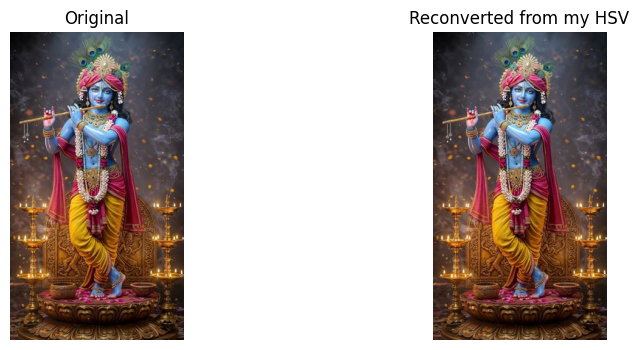

Mean abs diff: 0.32052708223777354


In [3]:
#part B

def rgb_to_hsv(rgb):
    img = rgb.astype('float32')
    R,G,B = img[:,:,0], img[:,:,1], img[:,:,2]
    Cmax = np.maximum(np.maximum(R,G),B)
    Cmin = np.minimum(np.minimum(R,G),B)
    delta = Cmax - Cmin
    H = np.zeros_like(Cmax, dtype='float32')
    mask = delta != 0
    mask_r = (Cmax==R) & mask
    mask_g = (Cmax==G) & mask
    mask_b = (Cmax==B) & mask
    H[mask_r] = 60 * (((G[mask_r]-B[mask_r]) / delta[mask_r]) % 6)
    H[mask_g] = 60 * (((B[mask_g]-R[mask_g]) / delta[mask_g]) + 2)
    H[mask_b] = 60 * (((R[mask_b]-G[mask_b]) / delta[mask_b]) + 4)
    H_op = H / 2.0
    S = np.zeros_like(Cmax, dtype='float32')
    nz = Cmax != 0
    S[nz] = (delta[nz] / Cmax[nz])
    S_op = S * 255.0
    V = Cmax
    hsv = np.dstack([H_op, S_op, V])
    return np.clip(hsv, 0, [179,255,255]).astype(np.uint8)

hsv_my = rgb_to_hsv(img_rgb)
rgb_recon = cv2.cvtColor(hsv_my, cv2.COLOR_HSV2RGB)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
imshow_rgb(img_rgb, "Original")
plt.subplot(1,2,2)
imshow_rgb(rgb_recon, "Reconverted from my HSV")
plt.show()
print("Mean abs diff:", np.mean(np.abs(img_rgb.astype(int)-rgb_recon.astype(int))))

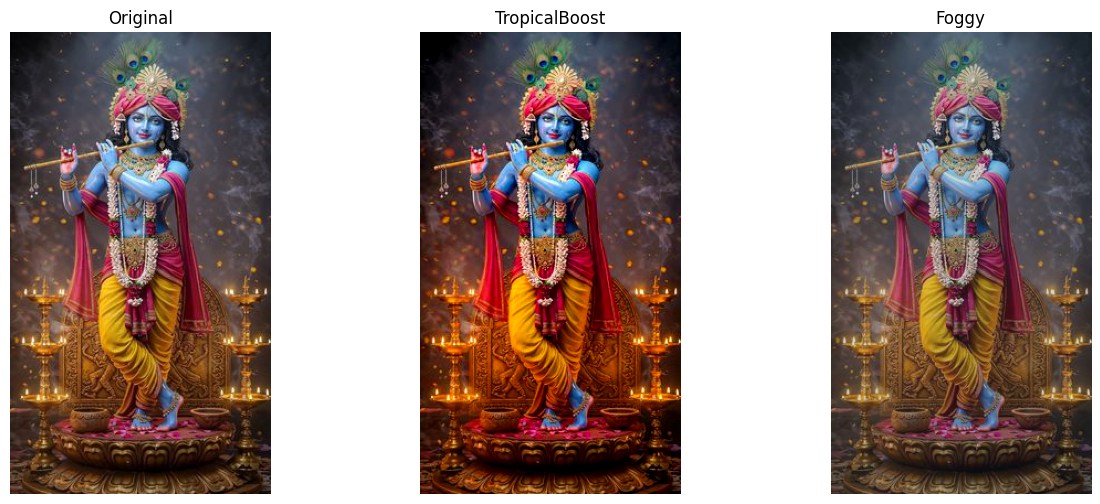

In [4]:
# Part C

def tropical_boost(rgb, sat_scale=1.3, contrast_alpha=1.15, warm_strength=0.10):
    hsv = rgb_to_hsv(rgb)
    H = hsv[:,:,0].astype('float32')
    S = hsv[:,:,1].astype('float32')
    V = hsv[:,:,2].astype('float32')

    S = np.clip(S * sat_scale, 0, 255)

    rgb_after = cv2.cvtColor(np.dstack([H,S,V]).astype(np.uint8), cv2.COLOR_HSV2RGB)
    rgb_after = rgb_after.astype('float32')

    out = (rgb_after - 128) * contrast_alpha + 128
    out[:,:,0] *= (1 + warm_strength)
    out[:,:,2] *= (1 - warm_strength * 0.6)

    return np.clip(out,0,255).astype(np.uint8)


def foggy(rgb, fog_strength=0.12, gamma=1.06):
    imgf = rgb.astype('float32')
    reduced = (imgf - 128)*0.95 + 128
    lum = 0.299*reduced[:,:,0] + 0.587*reduced[:,:,1] + 0.114*reduced[:,:,2]
    lumn = lum / 255

    shadow = (0.95,1.02,1.05)
    highlight = (1.02,0.98,0.95)

    out = np.empty_like(reduced)
    for c in range(3):
        out[:,:,c] = reduced[:,:,c] * (shadow[c]*(1-lumn) + highlight[c]*lumn)

    out = np.clip((np.clip(out/255,0,1) ** (1/gamma)) * 255, 0, 255)

    fog_layer = np.ones_like(out) * np.array([18,48,72])
    out_final = out*(1 - fog_strength) + fog_layer*fog_strength

    return np.clip(out_final,0,255).astype(np.uint8)


trop = tropical_boost(img_rgb)
fog = foggy(img_rgb)

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
imshow_rgb(img_rgb, "Original")
plt.subplot(1,3,2)
imshow_rgb(trop, "TropicalBoost")
plt.subplot(1,3,3)
imshow_rgb(fog, "Foggy")
plt.show()



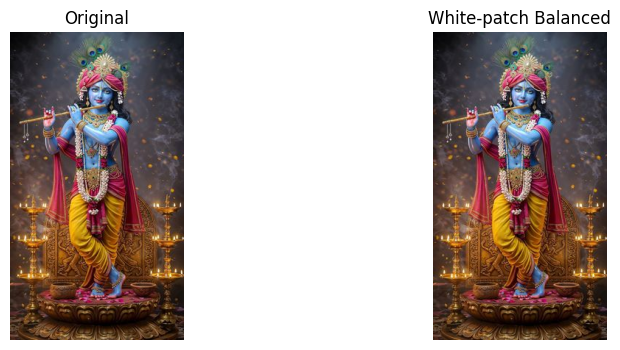

In [5]:
#part D

def white_patch_balance(img):
    f = img.astype('float32')
    mr, mg, mb = f[:,:,0].max(), f[:,:,1].max(), f[:,:,2].max()
    sr = 255.0/mr if mr>0 else 1.0
    sg = 255.0/mg if mg>0 else 1.0
    sb = 255.0/mb if mb>0 else 1.0
    out = f.copy()
    out[:,:,0] *= sr; out[:,:,1] *= sg; out[:,:,2] *= sb
    return np.clip(out,0,255).astype(np.uint8)

wb = white_patch_balance(img_rgb)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
imshow_rgb(img_rgb, "Original")
plt.subplot(1,2,2)
imshow_rgb(wb, "White-patch Balanced")
plt.show()

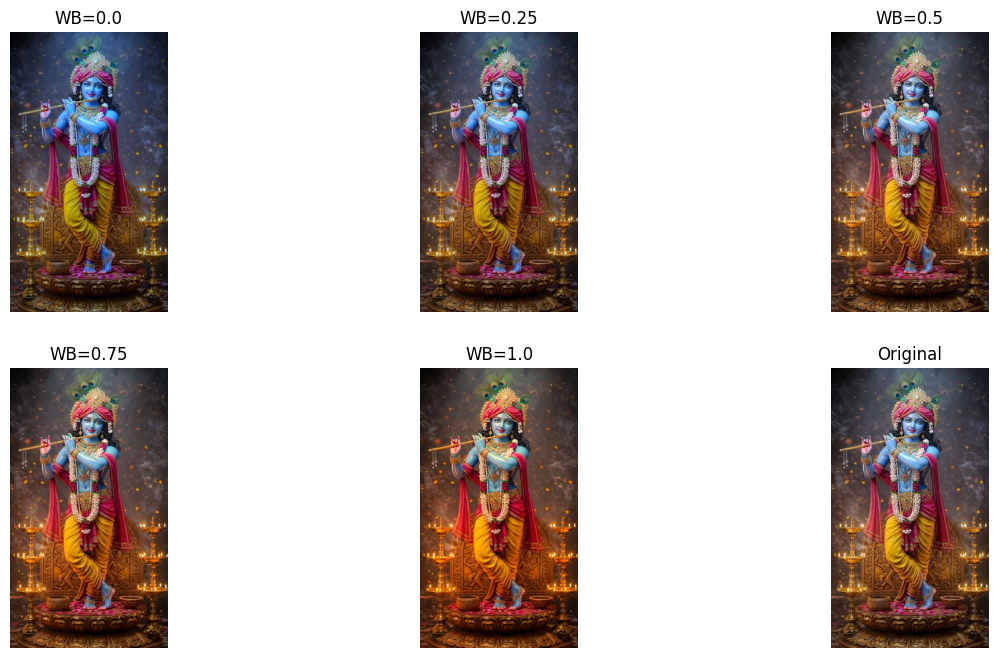

In [6]:
#part E

def white_balance(img, value=0.5):
    if not (0.0 <= value <= 1.0): raise ValueError("value 0..1")
    t = (value - 0.5) * 2.0
    r_scale = 1.0 + 0.18 * t; b_scale = 1.0 - 0.18 * t; g_scale = 1.0 + 0.02 * t
    out = img.astype('float32').copy()
    out[:,:,0] *= r_scale; out[:,:,1] *= g_scale; out[:,:,2] *= b_scale
    sat_factor = 1.0 + 0.15 * abs(t)
    hsv = rgb_to_hsv(np.clip(out,0,255).astype(np.uint8))
    H = hsv[:,:,0].astype('float32'); S = hsv[:,:,1].astype('float32'); V = hsv[:,:,2].astype('float32')
    S = np.clip(S * sat_factor, 0, 255)
    return cv2.cvtColor(np.dstack([H,S,V]).astype(np.uint8), cv2.COLOR_HSV2RGB)

vals = [0.0, 0.25, 0.5, 0.75, 1.0]
res = [white_balance(img_rgb, v) for v in vals]
plt.figure(figsize=(15,8))
for i,v in enumerate(vals):
    plt.subplot(2,3,i+1)
    imshow_rgb(res[i], f"WB={v}")
plt.subplot(2,3,6)
imshow_rgb(img_rgb, "Original")
plt.show()